In [ ]:
from google.colab import drive
drive.mount('mydrive')

Mounted at mydrive


In [ ]:
from zipfile import ZipFile
file_name = ['RAVDESS', 'SAVEE', 'CREMA']

for f in file_name:
  with ZipFile(f'/content/mydrive/MyDrive/My Files/Datasets/EmoSense/audio/{f}.zip', 'r') as zip:
    zip.extractall()
    print("Done")

Done
Done
Done


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio

In [ ]:
df = pd.read_csv('/content/mydrive/MyDrive/My Files/Datasets/EmoSense/audio/data_path.csv');
df.head()

,Emotions,Path
0,angry,data/RAVDESS/Actor_08/03-01-05-02-02-01-08.wav
1,angry,data/RAVDESS/Actor_08/03-01-05-02-01-02-08.wav
2,calm,data/RAVDESS/Actor_08/03-01-02-02-02-02-08.wav
3,disgust,data/RAVDESS/Actor_08/03-01-07-01-01-01-08.wav
4,surprise,data/RAVDESS/Actor_08/03-01-08-01-02-01-08.wav


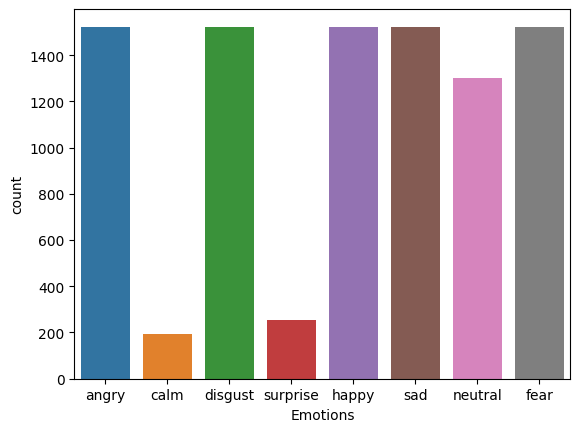

In [ ]:
import seaborn as sns
sns.countplot(x='Emotions', data=df)
plt.show()

22050


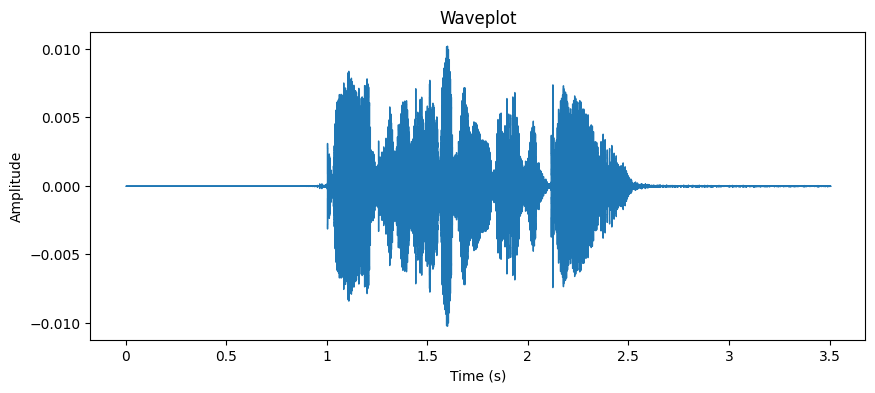

In [ ]:
def display_waveplot(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path)
    print(sr)
    # Plot waveplot
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveplot')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    ipd.display(Audio(y, rate=sr))

# Example usage
audio_path = df.iloc[1000, 1]
display_waveplot(audio_path)

In [ ]:
def get_mel_spectrogram(wave, sample_rate):
  # Compute Mel spectrogram
  mel_spectrogram = librosa.feature.melspectrogram(y=wave, sr = sample_rate, n_fft = 2048, hop_length = 512, n_mels = 90)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [ ]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

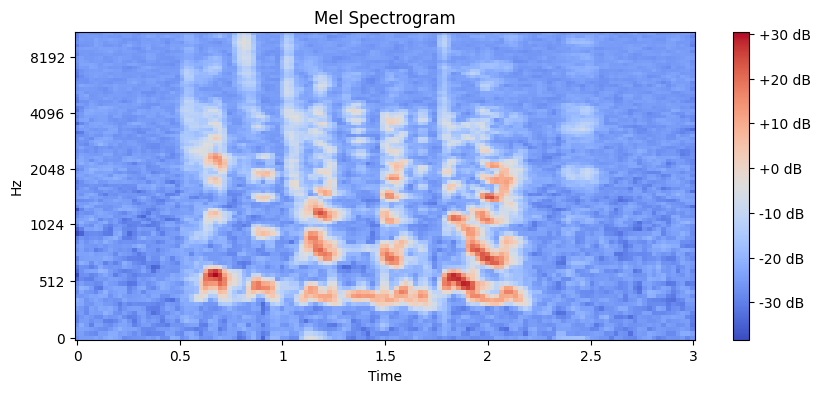

(90, 130)

In [ ]:
def extract_mel_spectrogram(audio_path, trim_duration=3, show_plot=False):
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, duration=trim_duration, offset=0.5)

        # Trim audio to 3 seconds
        if len(y) < sr * trim_duration:
            y = np.pad(y, (0, sr * trim_duration - len(y)))

        y = noise(y)

        # Extract mel spectrogram
        mel_spectrogram = get_mel_spectrogram(y, sr)

        # Display spectrogram
        if show_plot:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
            plt.title('Mel Spectrogram')
            plt.colorbar(format='%+2.0f dB')
            plt.show()

        return mel_spectrogram

    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

# Example usage:
audio_path = df.iloc[100, 1]
mel_spectrogram = extract_mel_spectrogram(audio_path, trim_duration=3, show_plot=True)
mel_spectrogram.shape

In [ ]:
%%time
original_data = df['Path'].apply(extract_mel_spectrogram)

In [ ]:
original_data

0       [[-55.11979, -42.94752, -40.872883, -40.728645...
1       [[-44.118576, -40.98951, -43.981956, -40.85147...
2       [[-46.284756, -45.391327, -46.948277, -46.7149...
3       [[-47.51806, -40.547966, -41.822163, -42.29560...
4       [[-38.927696, -36.858757, -41.355347, -42.1760...
                              ...                        
9357    [[-22.430468, -22.482393, -23.235971, -23.8934...
9358    [[-19.879642, -22.812452, -23.871927, -23.6178...
9359    [[-2.304726, -2.3657377, -3.4359617, -3.407049...
9360    [[6.3589244, 6.162717, 5.156707, 5.4151154, 5....
9361    [[8.358575, 8.431055, 7.3920517, 7.3248825, 7....
Name: Path, Length: 9362, dtype: object

In [ ]:
np.stack(original_data, axis=0).shape

(9362, 90, 130)

In [ ]:
%%time
noisy_data = df['Path'].apply(extract_mel_spectrogram)

CPU times: user 2min 47s, sys: 1min 56s, total: 4min 44s
Wall time: 2min 53s


In [ ]:
noisy_data

0       [[-21.61129071625566, -23.73115055268734, -31....
1       [[-26.74456602377979, -24.702477451432124, -24...
2       [[-48.286693036623596, -44.65134457591294, -46...
3       [[-39.59168279740591, -37.51962380535822, -38....
4       [[-37.40955464863332, -34.71302782421303, -37....
                              ...                        
9357    [[-22.165130726440996, -21.76205554881441, -21...
9358    [[-19.84505964755118, -22.78203940191295, -23....
9359    [[-2.832808742585006, -2.3017799761636737, -3....
9360    [[6.374209657544821, 6.166551713500377, 5.1490...
9361    [[8.38784993470476, 8.433698036798031, 7.43676...
Name: Path, Length: 9362, dtype: object

In [ ]:
np.stack(noisy_data, axis=0).shape

(9362, 90, 130)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, BatchNormalization, Dropout, TimeDistributed

In [ ]:
# Encode emotion labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(df['Emotions'])
Y[:5], Y.shape

(array([0, 0, 1, 2, 7]), (9362,))

In [ ]:
label_encoder.classes_

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype=object)

In [ ]:
Y = np.concatenate((Y, Y))
Y.shape

(18724,)

In [ ]:
data = np.concatenate((np.stack(original_data, axis=0), np.stack(noisy_data, axis=0)))
data.shape

(18724, 90, 130)

In [ ]:
import joblib

In [ ]:
# Save the array to a file
joblib.dump(data, 'X.joblib')
joblib.dump(Y, 'Y.joblib')

['Y.joblib']

In [ ]:
data = joblib.load('X.joblib')
Y = joblib.load('Y.joblib')

In [ ]:
data.shape

(18724, 90, 130)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape

(14979, 90, 130, 1)

In [ ]:
# Build the CNN-LSTM model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Flatten layer
model.add(TimeDistributed(Flatten()))

# Reshape for LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))

# Dense (fully connected) layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 88, 128, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 44, 64, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 44, 64, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 44, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 62, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 31, 64)       

In [ ]:
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join('models','audio_model_new.h5'), monitor='loss', save_best_only=True)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=16, callbacks=[checkpoint_callback, callback])

Epoch 1/60
937/937 [==============================] - 25s 16ms/step - loss: 1.7322 - accuracy: 0.3070 - val_loss: 1.6889 - val_accuracy: 0.2945 - lr: 0.0010
Epoch 2/60
  6/937 [..............................] - ETA: 10s - loss: 1.5308 - accuracy: 0.3854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


937/937 [==============================] - 13s 14ms/step - loss: 1.5863 - accuracy: 0.3648 - val_loss: 1.4854 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 3/60
937/937 [==============================] - 13s 13ms/step - loss: 1.5216 - accuracy: 0.4013 - val_loss: 1.4384 - val_accuracy: 0.4347 - lr: 0.0010
Epoch 4/60
937/937 [==============================] - 13s 14ms/step - loss: 1.4592 - accuracy: 0.4249 - val_loss: 1.4090 - val_accuracy: 0.4409 - lr: 0.0010
Epoch 5/60
937/937 [==============================] - 13s 13ms/step - loss: 1.3964 - accuracy: 0.4609 - val_loss: 1.8932 - val_accuracy: 0.2521 - lr: 0.0010
Epoch 6/60
937/937 [==============================] - 13s 14ms/step - loss: 1.3500 - accuracy: 0.4797 - val_loss: 1.3729 - val_accuracy: 0.4587 - lr: 0.0010
Epoch 7/60
937/937 [==============================] - 13s 14ms/step - loss: 1.2839 - accuracy: 0.5074 - val_loss: 1.2395 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 8/60
937/937 [==============================] - 13s 14ms/step -

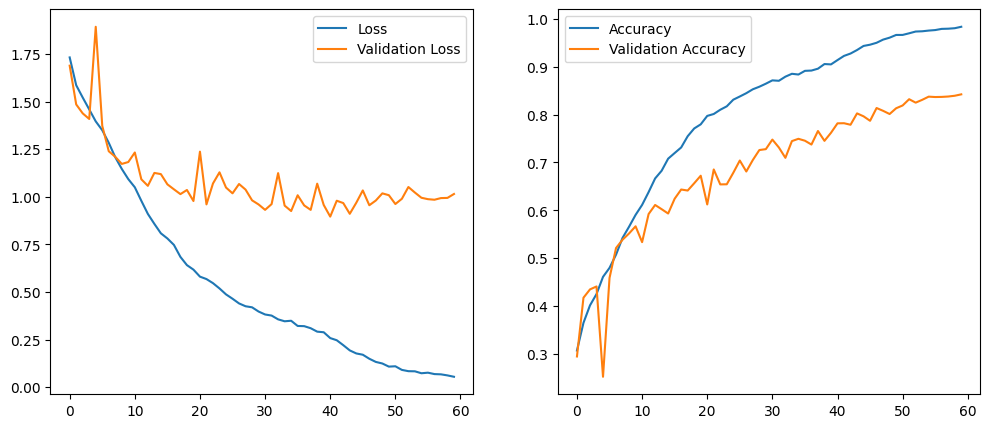

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/models/audio_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model1 = tf.keras.models.load_model('/content/models/audio_model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model1.predict(np.expand_dims(data, axis=-1))

586/586 [==============================] - 3s 5ms/step


In [ ]:
confusion_matrix(Y, np.argmax(y_pred, axis=1))

array([[2972,    0,   17,    7,   37,    9,    4,    0],
       [   0,  364,    0,    0,    0,    8,   12,    0],
       [  32,    0, 2924,   24,   11,   21,   34,    0],
       [  20,    3,   11, 2933,   34,   12,   27,    6],
       [  36,    0,   15,   32, 2937,   11,    9,    6],
       [   2,    0,    9,   14,   12, 2548,   20,    1],
       [   2,    0,   29,   21,    6,   38, 2950,    0],
       [   0,    0,    2,    3,    5,    2,    0,  492]])

In [ ]:
print(classification_report(Y, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3046
           1       0.99      0.95      0.97       384
           2       0.97      0.96      0.97      3046
           3       0.97      0.96      0.96      3046
           4       0.97      0.96      0.96      3046
           5       0.96      0.98      0.97      2606
           6       0.97      0.97      0.97      3046
           7       0.97      0.98      0.98       504

    accuracy                           0.97     18724
   macro avg       0.97      0.97      0.97     18724
weighted avg       0.97      0.97      0.97     18724



In [ ]:
new_data = df.sample().values
mel = extract_mel_spectrogram(new_data[0][1])
mel = np.expand_dims(np.expand_dims(mel, axis=0), axis=-1)
y_pred = model.predict(mel)
output = np.argmax(y_pred, axis=1)
label_encoder.classes_[output], new_data[0][0]

1/1 [==============================] - 0s 29ms/step


(array(['neutral'], dtype=object), 'neutral')